## Imports & Data Loading

In [1]:
%%capture
!pip install datasets

In [5]:
%%capture
# Importing the Required Pacakges and Libraries

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Dataset
from datasets import load_dataset

# tensorflow
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# other
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings

# Suppressing Warnings
warnings.filterwarnings("ignore")

2024-03-07 02:03:25.045290: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 02:03:25.074755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 02:03:25.074784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 02:03:25.076018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 02:03:25.081745: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 02:03:25.082258: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
# loading the Dataset and viewing it's structure
dataset = load_dataset("cifar10")
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

Text(0.5, 1.0, '0')

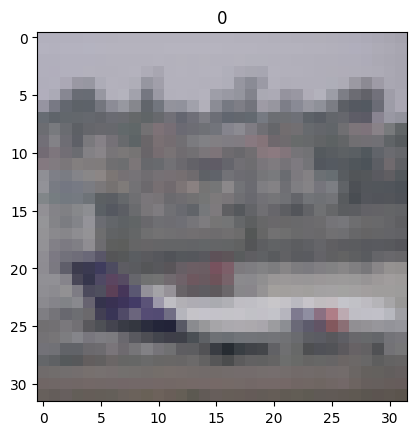

In [7]:
# Viewing Sample Image from Training Data
element = next(iter(dataset["train"]))
plt.imshow(element["img"])
plt.title(element["label"])

> ## Data Preprocessing

> The input image data is converted into numpy arrays which are normalized between 0 and 1 and have a dimesion of 1 row and 32x32x3 columns.

> ### Training Data

In [8]:
X_train = np.array(
    [(np.array(i)[None, ...] / 255.0).flatten() for i in dataset["train"]["img"][:]]
)  # .reshape(-1, 32 * 32 * 3)
y_train = np.array(dataset["train"]["label"][:])

> ### Test Data

In [9]:
X_test = np.array(
    [(np.array(i)[None, ...] / 255.0).flatten() for i in dataset["test"]["img"][:]]
)  # .reshape(-1, 32 * 32 * 3)
y_test = np.array(dataset["test"]["label"][:])

> ## Model Performance without ResNet

> The data from the previous step is used to train a simple Random Forest model and logistic regression model to get a baseline performance.
> 
> The metricts used to evaluate the model are:
> - Accuracy
> - Time to Train and Predict
> - Confusion Matrix

> ### Random Forest Classifier with 150 Estimators

In [10]:
# Initializing the Model
model_rf_raw = RandomForestClassifier(n_estimators=150)

# Fitting the Model
t = time.time()
model_rf_raw.fit(X_train, y_train)
print(f"Training Time: {time.time() - t:.2f} Seconds")

Training Time: 230.53 Seconds


In [11]:
# Predicting the Test Data
t = time.time()
y_pred = model_rf_raw.predict(X_test)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.57 Seconds


In [12]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 46.70%
Confusion Matrix: 
[[564  40  54  29  28  16  24  26 160  59]
 [ 39 527  17  35  16  30  39  41  67 189]
 [105  43 329  75 144  68 125  58  23  30]
 [ 51  43  68 275  77 177 147  66  23  73]
 [ 52  16 137  52 403  40 155  91  27  27]
 [ 39  24  94 151  74 402  85  78  19  34]
 [ 11  32  79  74 102  61 565  29   7  40]
 [ 46  42  56  70  93  86  51 452  21  83]
 [ 96  88  17  27  20  34  13  22 606  77]
 [ 48 175  15  30  18  26  22  42  77 547]]


> ### Logistic Regression with 150 iterations

In [13]:
# Initializing the Model
model_lr_raw = LogisticRegression(
    max_iter=150, multi_class="multinomial", solver="lbfgs", random_state=42
)

# Fitting the Model
t = time.time()
model_lr_raw.fit(X_train, y_train)
print(f"Training Time: {time.time() - t:0.2f} Seconds")

Training Time: 44.41 Seconds


In [14]:
t = time.time()
y_pred = model_lr_raw.predict(X_test)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.06 Seconds


In [15]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 40.77%
Confusion Matrix: 
[[486  46  60  26  29  34  25  49 172  73]
 [ 56 472  30  35  27  31  35  52  85 177]
 [ 96  44 286  92 123  77 139  79  43  21]
 [ 40  62  98 260  60 192 141  52  37  58]
 [ 57  20 130  80 306  82 162 105  29  29]
 [ 37  49  96 163  90 328  89  69  47  32]
 [ 17  36  68 130  96  79 493  45  14  22]
 [ 43  50  72  70  82  83  44 446  37  73]
 [171  70  24  30   9  42  14  20 523  97]
 [ 70 172  26  22  18  26  51  48  90 477]]


> ## ResNet Optimized

> The raw data is embedded using a pre-trained ResNet model and the output is used to train a Random Forest and Logistic Regression model. The metrics used to evaluate the model are the same as the previous step.

> ### Embedding the Data using ResNet50

In [16]:
# Load a pretrained model
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,  # take any input shape, not just 224x224
    weights="imagenet",  # use the imagenet pretrained model
    pooling="avg",  # use global average pooling to get a 2048 vector from our image
)

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
%%capture
def preprocess(img):
    processed_img = preprocess_input(  # ResNet has its own preprocesser that needs to be used
        tf.image.resize(  # resize the image to (224,224)
            np.array(img), (224, 224) 
        )
    )[None]
    return processed_img


# using the model to predict the images
X_train_resnet = np.array(
    [model.predict(preprocess(i)) for i in dataset["train"]["img"][:]]
).reshape(-1, 2048)
X_test_resnet = np.array(
    [model.predict(preprocess(i)) for i in dataset["test"]["img"][:]]
).reshape(-1, 2048)

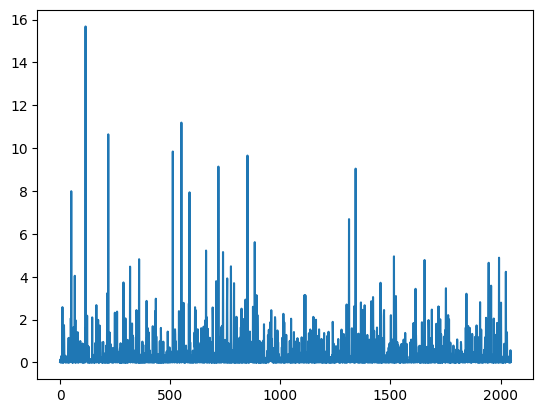

In [18]:
# Example of the ResNet50 Vector
plt.plot(X_train_resnet[0].flatten())

> ### Random Forest Classifier with 150 Estimators

In [19]:
# Initializing the Model
resnet_RF = RandomForestClassifier(n_estimators=150)

# Fitting the Model
t = time.time()
resnet_RF.fit(X_train_resnet, y_train)
print(f"Training Time: {time.time() - t:.2f} Seconds")

Training Time: 426.25 Seconds


In [20]:
# predicting the test data
t = time.time()
y_pred = resnet_RF.predict(X_test_resnet)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.62 Seconds


In [21]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 86.53%
Confusion Matrix: 
[[891   6  18   7   4   2   3   2  51  16]
 [  7 935   0   3   1   0   1   1   3  49]
 [ 42   1 804  26  56  18  38   8   4   3]
 [  7   3  33 752  32 100  44  17   3   9]
 [  9   0  38  28 840   6  33  42   3   1]
 [  1   0  16 106  23 823   5  24   2   0]
 [  6   1  22  36  13   7 914   0   1   0]
 [ 10   2  12  27  49  25   2 862   8   3]
 [ 38  12   2   7   0   1   3   0 924  13]
 [ 16  57   1   1   1   1   1   0  14 908]]


> ### Logistic Regression with 150 iterations

In [22]:
# Initializing the Model
resnet_LR = LogisticRegression(
    max_iter=150, multi_class="multinomial", solver="lbfgs", random_state=42
)

# Fitting the Model
t = time.time()
resnet_LR.fit(X_train_resnet, y_train)
print(f"Training Time: {time.time() - t:0.2f} Seconds")

Training Time: 29.07 Seconds


In [23]:
# predicting the test data
t = time.time()
y_pred = resnet_LR.predict(X_test_resnet)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.09 Seconds


In [24]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 90.69%
Confusion Matrix: 
[[925   6  13   6   5   0   2   4  30   9]
 [ 10 947   0   1   0   0   1   4   6  31]
 [ 12   0 888  20  32   9  21  11   5   2]
 [  3   2  17 819  23  86  27  18   4   1]
 [  3   0  25  29 892  11  13  22   2   3]
 [  2   0   9  86  16 862   7  17   1   0]
 [  5   0  24  26   5   5 931   3   1   0]
 [  4   0   9  11  30  20   1 925   0   0]
 [ 31   6   4   0   1   1   1   0 948   8]
 [ 13  37   2   3   1   0   1   2   9 932]]


## Results
> The results of the models are as follows:
>
> | Model                        | Accuracy | Time to Train | Time to Predict |
> | ---------------------------- | -------- | ------------- | --------------- |
> | Random Forest                | 0.47     | 250.53s       | 0.57s           |
> | Logistic Regression          | 0.41     | 44.41s        | 0.06s           |
> | Decision Trees (ResNet)      | 0.87     | 426.25s       | 0.62s           |
> | Logistic Regression (ResNet) | 0.91     | 29.07s        | 0.09s           |
> 
> The time to embed the data using ResNet50 was higher than the time to embed normally. however, this led to both the models showing an improvement in terms of accuracy and and confusion matrix performance
